## Day 34 Lecture 1 Assignment

In this assignment, we will learn about SVR. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def print_vif(x):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [4]:
absent = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv', sep=';')

In [5]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


We previously used this dataset for KNN regression. Recall that we removed all correlated columns as well as columns that are a function of two or more other columns (like BMI and weight and height) as well as columns that are not useful to us (like ID).
We also created dummy variables for the categorical columns in our dataset.
Finally, we split the data into test and train (with test being 20% of the data).

Perform these actions below.

In [6]:
absent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [7]:
#answer below:
absent = absent.drop(columns=['ID', 'Weight', 'Height'])

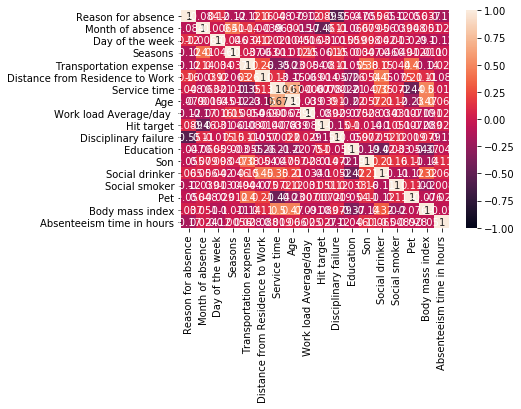

In [8]:
absent_corr = absent.corr()
sns.heatmap(absent_corr, vmin=-1, vmax=1, annot=True)

In [9]:
print_vif(absent)

VIF results
-------------------------------
const                              1304.597398
Reason for absence                    1.676013
Month of absence                      1.803451
Day of the week                       1.088748
Seasons                               1.389887
Transportation expense                1.678404
Distance from Residence to Work       1.841956
Service time                          3.256098
Age                                   2.396570
Work load Average/day                 1.232309
Hit target                            1.429004
Disciplinary failure                  1.647781
Education                             1.456928
Son                                   1.397407
Social drinker                        1.804946
Social smoker                         1.234030
Pet                                   1.656567
Body mass index                       1.933038
Absenteeism time in hours             1.173471
dtype: float64
-------------------------------



Scale the independent variables using the standard scaler

In [10]:
# answer below:
reason_counts = absent['Reason for absence'].value_counts() 
reason_keep = reason_counts[reason_counts > 10].index
absent = absent[absent["Reason for absence"].isin(reason_keep)]
absent['Reason for absence'].value_counts()


X = absent.drop(columns='Absenteeism time in hours')
y = absent['Absenteeism time in hours']


In [11]:
len(list(X.columns))

17

In [12]:
X.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Body mass index
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,30
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,31
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,31
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,24
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,30


In [13]:
X['Education'].value_counts()

1    578
3     73
2     37
4      4
Name: Education, dtype: int64

In [43]:
cat_cols = [
    'Reason for absence',
    'Month of absence',
    'Day of the week',
    'Seasons',
    'Education',
    
]
drop_cats = [
    23, 3,  2, 2, 1
]

num_cols = [
    'Hit target',
    'Son',
    'Transportation expense',
    'Distance from Residence to Work',
    'Service time',
    'Age',
    'Work load Average/day ',
    'Body mass index'
    
    
    
]


bin_columns = [
    'Disciplinary failure',
    'Social drinker',
    'Social smoker',
    'Pet',
    
]


preprocessing = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols)
    ], remainder='passthrough'
)

Generate an SVR model to predict the number of hours of absenteeism. Compare the train and test scores.

In [15]:
# answer below:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('svr', SVR()),
        
    ]
)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=[23, 3, 2,
                                                                      2, 1],
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Reason for absence',
                                                   'Month of absence',
                                                

In [18]:
pipeline.score(X_test, y_test)

0.021135162108660954

If you are unhappy with your model's performance, perform a grid search to optimize C. You may also want to compare something other than R squared, like MSE, and could try some other kernels than just linear.

In [19]:
y.value_counts()

8      184
2      154
3      105
1       84
4       59
0       44
16      17
24      13
40       7
5        7
32       5
64       3
80       3
56       2
120      2
104      1
7        1
48       1
Name: Absenteeism time in hours, dtype: int64

In [45]:
# answer below:
preprocessing = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(drop=True), cat_cols),
        ("scale", StandardScaler(), num_cols)
    ], remainder='passthrough'
)

pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('svr', SVR()),
        
    ]
)


grid = {
    'svr__kernel': ['rbf', 'linear'],
    'svr__epsilon': [0.1,1,10,20,30],
    "svr__C": [0.1,1,10,100,1000]
    
}
#SVR()
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=-1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
pipeline_cv.fit(X_train, y_train)


Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


ValueError: Wrong input for parameter `drop`. Expected 'first', None or array of objects, got <class 'numpy.ndarray'>

In [ ]:
print('Training score: {}'.format(pipeline_cv.score(X_train, y_train)))

In [38]:
(num_cols + cat_cols + bin_columns).sort() == X_train.columns.to_list().sort()

True

Create a homoscedasticity (residual) plot. Look back at your KNN regression exercise (Day 32 Lecture 1). How do your model results compare?

In [ ]:
# answer below:
